2024-05-13 20:07:24.372373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 20:07:24.372476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 20:07:24.632342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


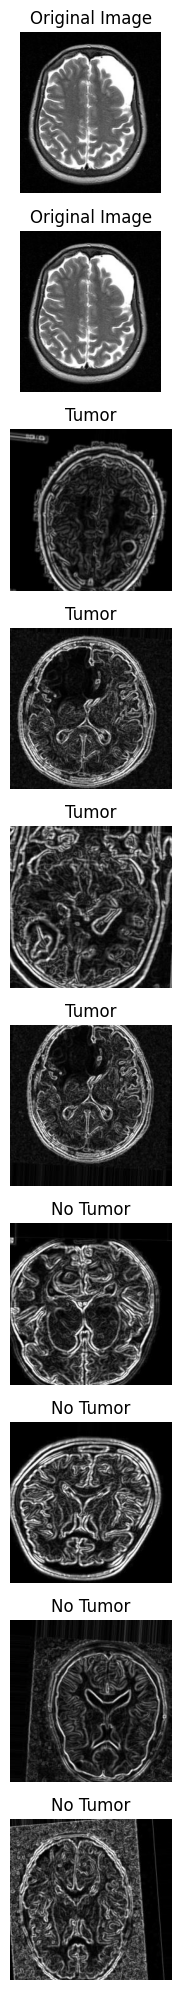

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
tumor_folder = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'
no_tumor_folder = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'

# New paths for saving preprocessed images
new_tumor_folder = '/kaggle/working/yes'
new_no_tumor_folder = '/kaggle/working/no'

# Create new directories if they don't exist
os.makedirs(new_tumor_folder, exist_ok=True)
os.makedirs(new_no_tumor_folder, exist_ok=True)

def preprocess_image(image_path, target_folder, label):
    # Load image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    
    # Resize image
    resized = cv2.resize(blurred, (256, 256))
    
    # Apply Sobel edge detection
    sobel_x = cv2.Sobel(resized, cv2.CV_64F, 1, 0, ksize=3)
    sobel_x = cv2.convertScaleAbs(sobel_x)
    sobel_y = cv2.Sobel(resized, cv2.CV_64F, 0, 1, ksize=3)
    sobel_y = cv2.convertScaleAbs(sobel_y)
    sobel_filtered = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)
    
    # Save preprocessed image
    filename = os.path.basename(image_path)
    new_path = os.path.join(target_folder, filename)
    cv2.imwrite(new_path, sobel_filtered)
    
    return new_path, label

# Create an image data generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Process images with tumor
for filename in os.listdir(tumor_folder):
    image_path = os.path.join(tumor_folder, filename)
    new_path, label = preprocess_image(image_path, new_tumor_folder, label=1)
    
    # Generate more images
    img = cv2.imread(new_path)
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=new_tumor_folder, save_prefix='gen_tumor', save_format='jpg'):
        i += 1
        if i >= 50:  # Generate 50 additional images per original image
            break

# Process images without tumor
for filename in os.listdir(no_tumor_folder):
    image_path = os.path.join(no_tumor_folder, filename)
    new_path, label = preprocess_image(image_path, new_no_tumor_folder, label=0)
    
    # Generate more images
    img = cv2.imread(new_path)
    img = img.reshape((1,) + img.shape)
    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=new_no_tumor_folder, save_prefix='gen_no_tumor', save_format='jpg'):
        i += 1
        if i >= 50:  # Generate 50 additional images per original image
            break

# Plot some samples
sample_tumor_path = os.path.join(new_tumor_folder, os.listdir(new_tumor_folder)[0])
sample_no_tumor_path = os.path.join(new_no_tumor_folder, os.listdir(new_no_tumor_folder)[0])

sample_tumor_image = cv2.imread(sample_tumor_path)
sample_no_tumor_image = cv2.imread(sample_no_tumor_path)
# Choose one image from the original tumor folder
original_tumor_image_path = os.path.join(tumor_folder, os.listdir(tumor_folder)[0])

# Load the image using OpenCV
original_tumor_image = cv2.imread(original_tumor_image_path)

# Plot few samples
plt.figure(figsize=(10, 20))  # Adjusted figsize for vertical layout
for i in range(10):
    if i <= 1:
        plt.subplot(10, 1, i+1)  # Adjusted subplot parameters for vertical layout
        plt.imshow(cv2.cvtColor(original_tumor_image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
    elif i < 6:
        plt.subplot(10, 1, i+1)  # Adjusted subplot parameters for vertical layout
        sample_tumor_path = os.path.join(new_tumor_folder, os.listdir(new_tumor_folder)[i-1])
        sample_tumor_image = cv2.imread(sample_tumor_path)
        plt.imshow(cv2.cvtColor(sample_tumor_image, cv2.COLOR_BGR2RGB))
        plt.title('Tumor')
        plt.axis('off')
    else:
        plt.subplot(10, 1, i+1)  # Adjusted subplot parameters for vertical layout
        sample_no_tumor_path = os.path.join(new_no_tumor_folder, os.listdir(new_no_tumor_folder)[i-3])
        sample_no_tumor_image = cv2.imread(sample_no_tumor_path)
        plt.imshow(cv2.cvtColor(sample_no_tumor_image, cv2.COLOR_BGR2RGB))
        plt.title('No Tumor')
        plt.axis('off')

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

In [2]:
import os
import random
from sklearn.model_selection import train_test_split

# Paths to preprocessed images
tumor_folder = '/kaggle/working/yes'
no_tumor_folder = '/kaggle/working/no'

# List all the preprocessed tumor and non-tumor images
tumor_images = [os.path.join(tumor_folder, filename) for filename in os.listdir(tumor_folder)]
no_tumor_images = [os.path.join(no_tumor_folder, filename) for filename in os.listdir(no_tumor_folder)]

# Labels
tumor_labels = [1] * len(tumor_images)
no_tumor_labels = [0] * len(no_tumor_images)

# Combine image paths and labels
all_images = tumor_images + no_tumor_images
all_labels = tumor_labels + no_tumor_labels

# Shuffle the data
data = list(zip(all_images, all_labels))
random.shuffle(data)
all_images, all_labels = zip(*data)

# Split the data into train and test sets (80% train, 20% test)
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Sanity check
print("Total images:", len(all_images))
print("Train images:", len(train_images))
print("Test images:", len(test_images))

Total images: 9555
Train images: 7644
Test images: 1911


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Input(shape=(256, 256, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.3),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.3),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.3),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Dropout(0.3),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Define the optimizer with a specific learning rate

optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,233,409 (50.48 MB)

 Trainable params: 13,233,409 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Function to load and preprocess images
def preprocess_images(image_paths, labels):
    images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        img = cv2.resize(img, (256, 256))  # Resize image
        img = img.astype('float32') / 255.0  # Normalize pixel values
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        images.append(img)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load and preprocess train images
train_images, train_labels = preprocess_images(train_images, train_labels)

# Shuffle train data
train_images, train_labels = shuffle(train_images, train_labels)

# Load and preprocess test images
test_images, test_labels = preprocess_images(test_images, test_labels)

# Reshape train and test data to match the model input shape
train_images = train_images.reshape(train_images.shape[0], 256, 256, 1)
test_images = test_images.reshape(test_images.shape[0], 256, 256, 1)

In [5]:
# Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels))

Epoch 1/20
  1/120 ━━━━━━━━━━━━━━━━━━━━ 56:14 28s/step - accuracy: 0.4844 - loss: 0.7001

I0000 00:00:1715631112.219723     177 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715631112.239148     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6607 - loss: 0.8487

W0000 00:00:1715631148.279888     179 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 72s 363ms/step - accuracy: 0.6611 - loss: 0.8467 - val_accuracy: 0.7755 - val_loss: 0.5361
Epoch 2/20
  1/120 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.6875 - loss: 0.4926

W0000 00:00:1715631155.606052     177 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.7956 - loss: 0.4300 - val_accuracy: 0.8472 - val_loss: 0.4362
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.8576 - loss: 0.3295 - val_accuracy: 0.8791 - val_loss: 0.3666
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.9086 - loss: 0.2295 - val_accuracy: 0.9084 - val_loss: 0.2869
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.9361 - loss: 0.1661 - val_accuracy: 0.9210 - val_loss: 0.2268
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.9608 - loss: 0.1010 - val_accuracy: 0.9341 - val_loss: 0.2350
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.9705 - loss: 0.0840 - val_accuracy: 0.9435 - val_loss: 0.1774
Epoch 8/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.9758 - loss: 0.0639 - val_accuracy: 0.9597 - val_loss: 0.1192
Epoch 9/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.9800 - loss: 0.0550 - val

In [7]:
loss, accuracy = model.evaluate(test_images, test_labels)
print("Test Loss: {:.2f}%".format(loss * 100))
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9773 - loss: 0.0651
Test Loss: 6.74%
Test Accuracy: 97.54%


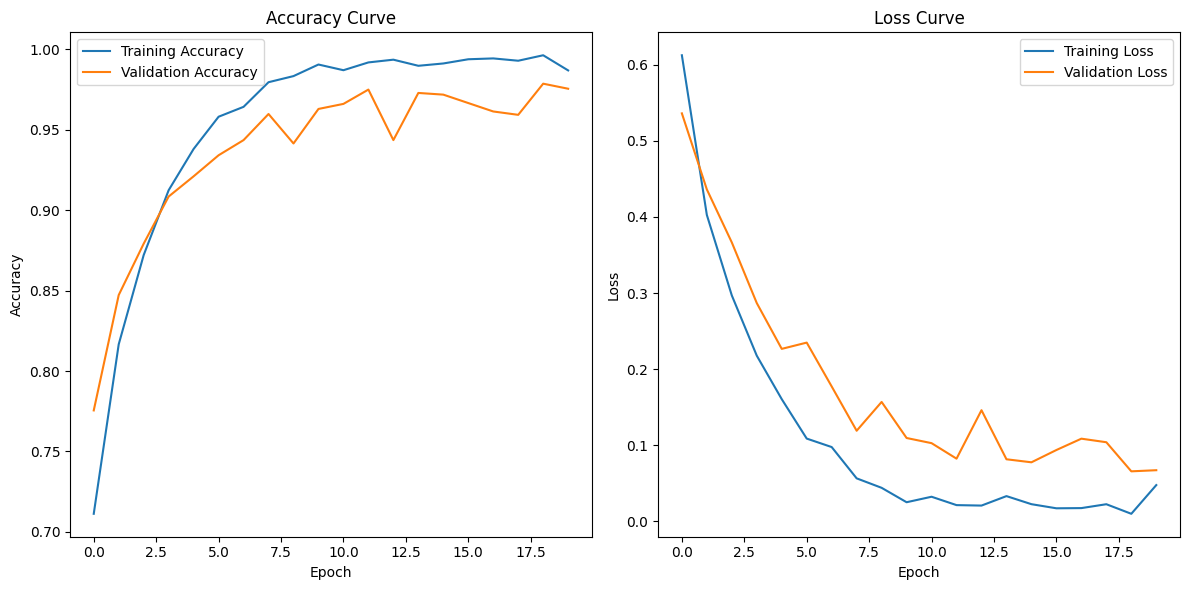

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [81]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load and preprocess new images
def preprocess_new_images(image_paths):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(256, 256))
        img = img_to_array(img.convert('L')) / 255.0  # Convert to grayscale and normalize
        images.append(img)
    return np.array(images)

# Example paths to new images
new_image_paths = ["/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/10 no.jpg",
                   "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/21 no.jpg",
                   "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/32 no.jpg",
                   "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y107.jpg",
                   "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y116.JPG",
                   "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y148.JPG"]

# Preprocess new images
new_images = preprocess_new_images(new_image_paths)

# Reshape new images to match model input shape
new_images = np.expand_dims(new_images, axis=-1)

# Make predictions on new images
predictions = model.predict(new_images)

# Display predictions
for i, prediction in enumerate(predictions):
    if prediction > 0.5:
        print("Image {} TUMOR DETECTED!!!".format(new_image_paths[i]))
    else:
        print("Image {} NO TUMOR DETECTED!!!".format(new_image_paths[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image /kaggle/input/brain-mri-images-for-brain-tumor-detection/no/10 no.jpg NO TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-images-for-brain-tumor-detection/no/21 no.jpg NO TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-images-for-brain-tumor-detection/no/32 no.jpg NO TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y107.jpg TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y116.JPG TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y148.JPG TUMOR DETECTED!!!


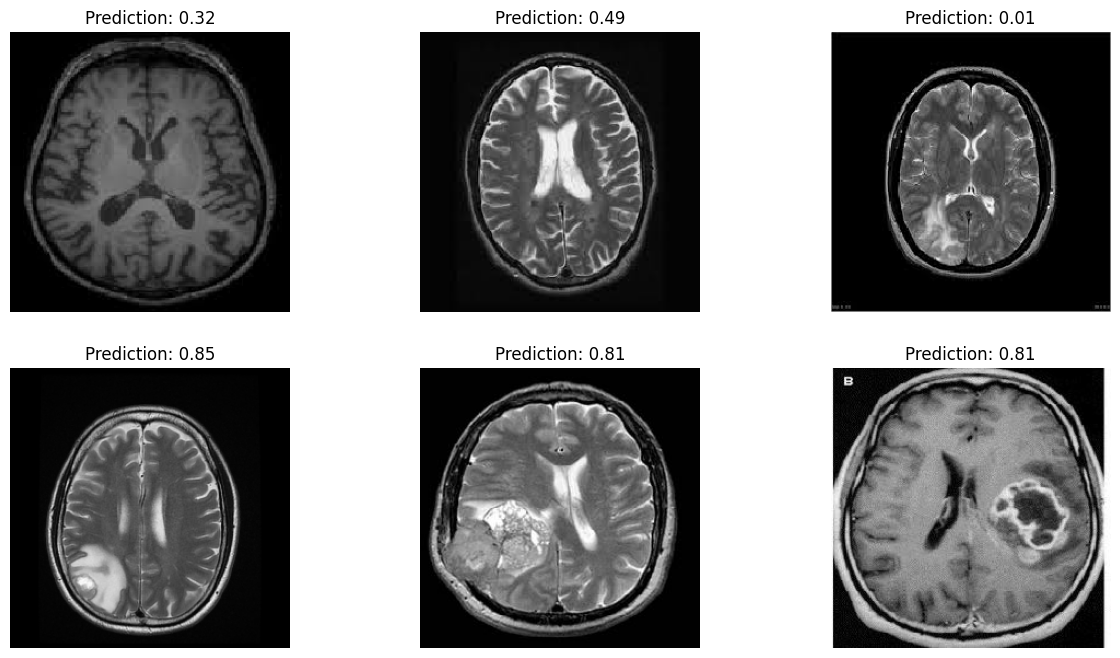

In [82]:
plt.figure(figsize=(15, 8))
for i, (image_path, prediction) in enumerate(zip(new_image_paths, predictions)):
    plt.subplot(2, 3, i+1)
    img = load_img(image_path, target_size=(256, 256))
    plt.imshow(img, cmap='gray')
    plt.title('Prediction: {:.2f}'.format(prediction[0]))
    plt.axis('off')
plt.show()

In [65]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load and preprocess new images
def preprocess_new_images(image_paths):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(256, 256))
        img = img_to_array(img.convert('L')) / 255.0  # Convert to grayscale and normalize
        images.append(img)
    return np.array(images)

# Example paths to new images
new_image_paths = ["/kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/negative/16.jpg",
                   "/kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/negative/26.jpg",
                   "/kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/negative/13.jpg",
                   "/kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/positive/104.jpg",
                   "/kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/positive/119.jpg",
                  "/kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/positive/114.jpg"]

# Preprocess new images
new_images = preprocess_new_images(new_image_paths)

# Reshape new images to match model input shape
new_images = np.expand_dims(new_images, axis=-1)

# Make predictions on new images
predictions = model.predict(new_images)

# Display predictions
for i, prediction in enumerate(predictions):
    if prediction > 0.5:
        print("Image {} TUMOR DETECTED!!!".format(new_image_paths[i]))
    else:
        print("Image {} NO TUMOR DETECTED!!!".format(new_image_paths[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image /kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/negative/16.jpg NO TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/negative/26.jpg NO TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/negative/13.jpg NO TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/positive/104.jpg TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/positive/119.jpg TUMOR DETECTED!!!
Image /kaggle/input/brain-mri-scan-images-tumor-detection/brain_mri_scan_images/positive/114.jpg TUMOR DETECTED!!!


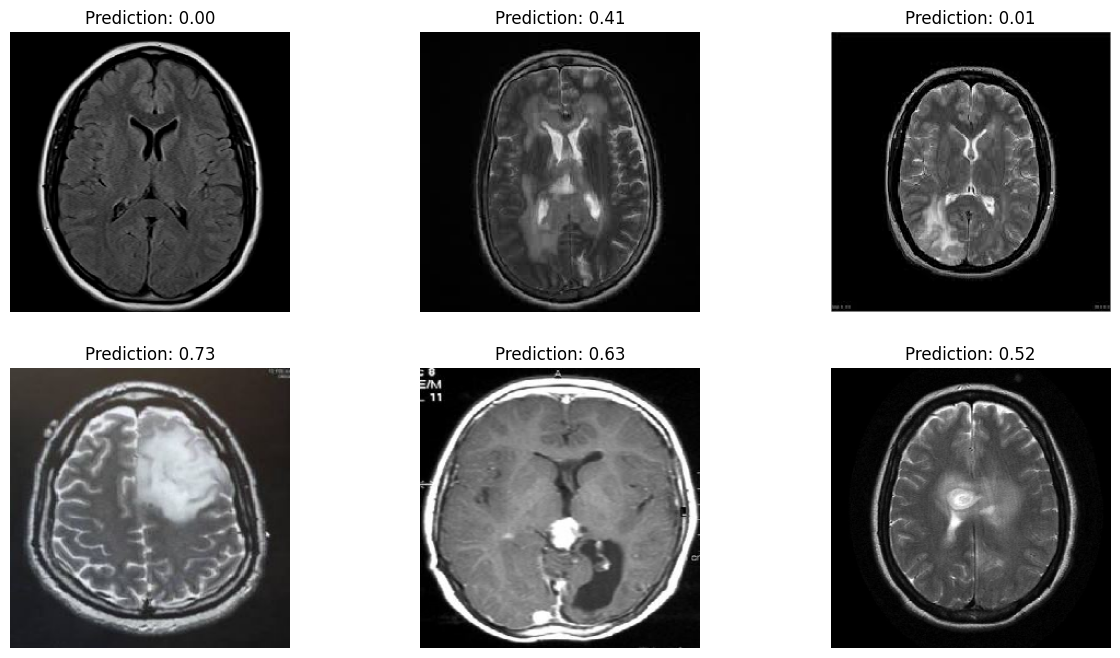

In [66]:
plt.figure(figsize=(15, 8))
for i, (image_path, prediction) in enumerate(zip(new_image_paths, predictions)):
    plt.subplot(2, 3, i+1)
    img = load_img(image_path, target_size=(256, 256))
    plt.imshow(img, cmap='gray')
    plt.title('Prediction: {:.2f}'.format(prediction[0]))
    plt.axis('off')
plt.show()